## Goal of Experiment 3: Use even amount of data from from normal to abnormal and test on experiment 1 and experiment 2 test set

In [1]:
import pandas as pd
import seaborn as sns
import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from keras.preprocessing.sequence import pad_sequences
import os, sys, time
from math import floor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from collections import OrderedDict
# from tensorflow.python.ops import math_ops
# import tensorflow.keras.backend as kb
from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
_check_tf_version()
from tensorflow_addons import losses
# Custom Functions
# Added to path by using sys.path.append('')
# sys.path.append('/home/akanu/git/anomalous_pred/custom_functions')
# sys.path.insert(0,'/home/akanu/git/anomalous_pred/custom_functions')
# sys.path.append('/mnt/roahm/users/akanu/git/anomalous_pred/custom_functions')
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min
from custom_metrics import bb_intersection_over_union, bb_intersection_over_union_np
from coordinate_change import xywh_tlbr, tlbr_xywh
from pedsort import pedsort
from load_data_binary_class import return_indices, binary_data_split, same_ratio_split_train_val
from load_data_binary_class import one_weight_ratio_train
from TP_TN_FP_FN import seperate_misclassifed_examples, sort_TP_TN_FP_FN_by_vid_n_frame
from plot_all_videos import cycle_through_videos

# Kmeans
from sklearn.cluster import KMeans

# Need to figue out why this is not working
# from persistence1d import RunPersistence


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
plt.style.use('classic')

# GPU check

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


# Load Data

In [6]:
frames = 20

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

# Don't forget to change to xywh 
traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre', to_xywh=True)
testdict = Boxes(loc_files_test, box_test_txt, frames, pad ='pre', to_xywh = True)
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict) #splits by which predicted frames are normal or not

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.3)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Load or Train Model

In [8]:
# Need to figure out a better way to add more Python Paths

In [9]:
sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
from lstm_models import lstm_xywh_avenue_20

In [10]:
model_loc = '/home/akanu/git/anomalous_pred/saved_models'
nc=['lstm', 'xywh', 'avenue', frames]

In [11]:
loaded_model = os.path.join(model_loc,
                            '{}_{}_{}_{}.h5'.format(nc[0], nc[1],nc[2], nc[3]))
lstm_20 = tf.keras.models.load_model(loaded_model,  
                                   custom_objects = {'loss':'mse'} , 
                                   compile=True)


# Weighted Loss

In [12]:
# weight ratio for inital bias and ratio for weighted binary
# might be different thats why error could be occuring
# initial_bias = np.log([pos/neg])
weight_ratio =1
initial_bias = np.log([weight_ratio]) # want to take out of here
initial_bias
# Note that value is negative now

array([0.])

labels * -log(sigmoid(logits)) * pos_weight +
    (1 - labels) * -log(1 - sigmoid(logits)) 
    
This means that the into must be 1/weight ratio. Assuming
weight_ratio = pos/neg
    

In [13]:
# def weighted_binary(y,x):
#     return tf.nn.weighted_cross_entropy_with_logits(y,x,pos_weight = 1/weight_ratio)

In [14]:
def loss(y_true, y_pred):
    when_y_1 = y_true*tf.keras.backend.log(y_pred)*(1/weight_ratio)
    neg_y_pred = Lambda(lambda x: -x)(y_pred)
    when_y_0 = ( 1+Lambda(lambda x: -x)(y_true))*tf.keras.backend.log(1+neg_y_pred )
    
    weighted_cross_entr = Lambda(lambda x: -x)(when_y_0+when_y_1)
    return weighted_cross_entr

# Load Data for Binary Network Experiment 1
## Seed was 24
## Then I used 81
## Then 23
# Then 35

In [15]:
seed_exp_1 = 23

In [16]:
indices_exp_1 = return_indices(testdict['abnormal'], 
                               abnormal_split = 0.5, 
                               seed=seed_exp_1)


In [17]:
x_exp_1,y_exp_1 = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )

In [18]:
x_exp_1.shape

(115624, 20, 4)

COuld probably make binary data split easier for adding more features
by performing data auc outside and inputing that into function. Might look into as well to make code more maintainable. Could allow me to call the function in some ratio split train val function.

In [19]:
train_full_x_exp_1,train_full_y_exp_1, test_x_exp_1, test_y_exp_1 = binary_data_split(x_exp_1,
                                                                          y_exp_1,
                                                                          lstm_20,
                                                                          indices_exp_1)

In [20]:
print('Comparing shape length of train_full_x and test_x \n' +
     'train_full_x: {}, test_x:{}'.format(train_full_x_exp_1.shape,
                                         test_x_exp_1.shape))

Comparing shape length of train_full_x and test_x 
train_full_x: (2, 112694), test_x:(2, 2930)


In [21]:
train_x_even_split_exp_1, train_y_even_split_exp_1 = one_weight_ratio_train(
                                        train_full_x_exp_1,
                                        train_full_y_exp_1)

In [22]:
val_x_exp_1, val_y_exp_1, train_x_exp_1, train_y_exp_1 = same_ratio_split_train_val(
    train_x_even_split_exp_1,train_y_even_split_exp_1, val_ratio = 0.3)
# weight_ratio = len(indices_exp_1[0])/len(indices_exp_1[1])
weight_ratio =1


In [23]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
# Note that I need to index into correct column as one is IOU
# and last column is index values to map back into datadicg
train_bm_exp_1 = tf.data.Dataset.from_tensor_slices((train_x_exp_1[0,:],train_y_exp_1))
train_bm_exp_1 = train_bm_exp_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_bm_exp_1 = tf.data.Dataset.from_tensor_slices((val_x_exp_1[0,:],val_y_exp_1))
val_bm_exp_1 = val_bm_exp_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [24]:
sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
from binary_classification import Dense_5_Drop_2

In [25]:
nc_bin_exp_1 = ['seed{}_Dense_5_Drop_5_exp_1', 'xywh','avenue', frames, 0.500]

In [26]:
nc_bin_exp_1[0] = nc_bin_exp_1[0].format(seed_exp_1)

In [27]:
nc_bin_exp_1

['seed23_Dense_5_Drop_5_exp_1', 'xywh', 'avenue', 20, 0.5]

In [28]:
model_loc_exp = os.path.join(model_loc, 'Experiment_3')
model_loc_exp

'/home/akanu/git/anomalous_pred/saved_models/Experiment_3'

# Train Data Experiment 1 Data


In [29]:
# binary_model = create_baseline_weighted(initial_bias)
bm_history_exp_1,bm_model_exp_1 = Dense_5_Drop_2(train_bm_exp_1,
                              val_bm_exp_1,
                              os.path.join(model_loc_exp, 
                                            'using_exp_1_method'),
                              nc_bin_exp_1,
                              loss,
                              initial_bias,
                              1000,
                              save_model=False,
                              patience = 50
                             )


Epoch 1/1000
65/65 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.5073 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 2/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4946 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 3/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.4956 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 4/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5019 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 5/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.4790 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 6/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4937 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 7/1000
65/65 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4854 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 

KeyboardInterrupt: 

# Plot and Save Results using experiment
# 1 methodogly

In [30]:
# This is location where  plots are saved
plot_loc = '/home/akanu/git/anomalous_pred/plots/experiment_3/Avenue'
# nc_bin provides unique idenifer for plots
nc_bin_exp_1


['seed23_Dense_5_Drop_5_exp_1', 'xywh', 'avenue', 20, 0.5]

In [31]:
plot_loc_exp_1 = os.path.join(plot_loc, 'using_exp_1_method')
plot_loc_exp_1

'/home/akanu/git/anomalous_pred/plots/experiment_3/Avenue/using_exp_1_method'

NameError: name 'bm_history_exp_1' is not defined

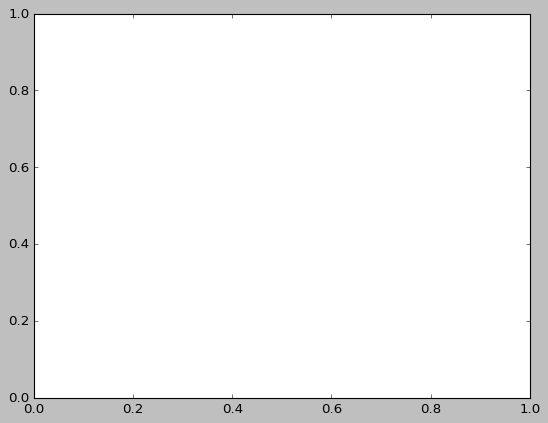

In [32]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history_exp_1.history['loss'], '-', color='black',label='loss')
ax.plot(bm_history_exp_1.history['val_loss'],'-',color='red' ,label ='Validation loss')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Zero Initial Bias Last Layer')
# fig.savefig(os.path.join(plot_loc_exp_1, 'loss_{}_{}_{}_{}_{}.jpg'.format(nc_bin_exp_1[0],
#                                                                     nc_bin_exp_1[1],
#                                                                     nc_bin_exp_1[2],
#                                                                     nc_bin_exp_1[3],
#                                                                     nc_bin_exp_1[4])))

NameError: name 'bm_history_exp_1' is not defined

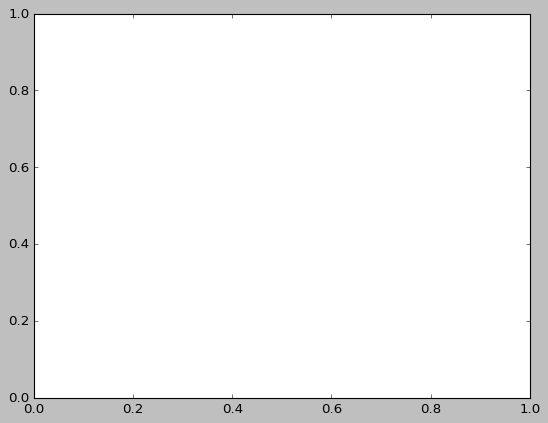

In [33]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history_exp_1.history['accuracy'], '-*', color='black',label='Acc')
ax.plot(bm_history_exp_1.history['val_accuracy'],'-o', color='red', label ='Validation Acc')
ax.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Zero Initial Bias Last Layer')
# fig.savefig(os.path.join(plot_loc_exp_1, 'acc_{}_{}_{}_{}_{}.jpg'.format(nc_bin_exp_1[0],
#                                                                     nc_bin_exp_1[1],
#                                                                     nc_bin_exp_1[2],
#                                                                     nc_bin_exp_1[3],
#                                                                     nc_bin_exp_1[4])))

NameError: name 'bm_model_exp_1' is not defined

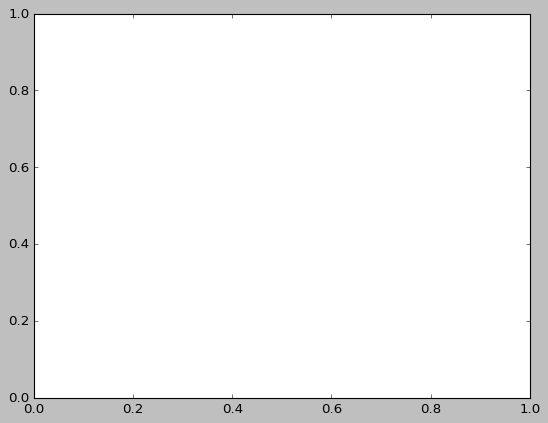

In [34]:
fig,ax = plt.subplots(1,1)
ax.plot(bm_model_exp_1.predict(test_x_exp_1[0,:]), '*')
plt.title('Zero Initial Bias Last Layer')
plt.ylabel('Predicted Y')
# fig.savefig(os.path.join(plot_loc_exp_1, 'scatter_{}_{}_{}_{}_{}.jpg'.format(nc_bin_exp_1[0],
#                                                                     nc_bin_exp_1[1],
#                                                                     nc_bin_exp_1[2],
#                                                                     nc_bin_exp_1[3],
#                                                                     nc_bin_exp_1[4])))

# Load Binary Model 

In [35]:
load_binary_model = os.path.join(model_loc_exp,'using_exp_1_method')
load_binary_model = os.path.join(load_binary_model, 
                     '{}_{}_{}_{}_{:.3f}.h5'.format(nc_bin_exp_1[0],
                                                   nc_bin_exp_1[1], 
                                                   nc_bin_exp_1[2],
                                                   nc_bin_exp_1[3],
                                                   nc_bin_exp_1[4] ) )
load_binary_model

'/home/akanu/git/anomalous_pred/saved_models/Experiment_3/using_exp_1_method/seed23_Dense_5_Drop_5_exp_1_xywh_avenue_20_0.500.h5'

In [36]:
loaded_binary_model = tf.keras.models.load_model(load_binary_model,  
                                   custom_objects = {'loss': loss},
                                   compile = True)
bm_model_exp_1 = loaded_binary_model

# End of Loading Model

In [37]:
y_pred_exp_1 = bm_model_exp_1.predict(test_x_exp_1[0,:])

In [38]:
y_pred_exp_1 = bm_model_exp_1.predict(test_x_exp_1[0,:]) > 0.5
conf_matrix_exp_1 = tf.math.confusion_matrix(test_y_exp_1, y_pred_exp_1)
conf_matrix_exp_1

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1055,  410],
       [ 231, 1234]], dtype=int32)>

In [39]:
confusion_index_exp_1 = seperate_misclassifed_examples(bm_model_exp_1,
                                                       test_x_exp_1,
                                                       test_y_exp_1,
                                                        )

In [40]:
start = time.time()
s_TP_TN_FP_FN,s_boxes_dict = sort_TP_TN_FP_FN_by_vid_n_frame(testdict, confusion_index_exp_1 )
end = time.time()
print(end-start)

0.017059326171875


In [41]:
def indi_seq(data, video, frame):
    """
    Takes the data and find the video and frame so that 
    sequence can be inputted and creates smaller dict of one 
    sequence

    data: Format is keys are different videos
    video: video of interest. useful if in TN, TP, FN, FP. Ny that
            I mean that only inputed then the next immediate key is
            video numbers. For generic data this wouldn't work.
            As I would need to find the videos. Probably go back and 
            delete this funciton later on
    return output: same format as x_ppl_box,y_ppl_box etx
    """

    output ={}
    data = data['{}.txt'.format(video)]
    frames = data['frame_ppl_id'][:,-1,0]
    found_index_of_frame = np.where(frames==frame)

    
    for key in data.keys():

        output[key] = data[key][found_index_of_frame]

    
    return output




def plot_sequence(one_ped_seq, max1, min1, vid_key,pic_loc, loc_videos, xywh=False):
    """
    This will plot the sequences of the of one pedestrain
    Not computially efficent if you want to plot lots of pedestrain


    one_ped_seq: one pedestrain sequence: 'x_ppl_box', 'y_ppl_box',
                     'frame_ppl_id', 'video_file', 'abnormal'. From ind_seq
                     function
    max1:  scaling factor
    min1:  scaline factor
    vid_key: '01.txt' '01_02.txt'etx
    loc_videos: this are videos that are used to make plots
    pic_loc: need to save to different location depending on confusion
                    type and/or can input generic location to allow for
                    plotting all videos at the same sort_TP_TN_FP_FN_by_vid_n_frame                
    """

    x_input = one_ped_seq['x_ppl_box'].squeeze()
    # x_scal,y_scal = norm_train_max_min(data_dict = data, max1 = max1,min1 =min1)
    last_frame = one_ped_seq['frame_ppl_id'][-1,-2,0]
    size = len(x_input)
    

    next_frame_index, j, frame_count = 0, 0, 0

    loc_vid = os.path.join(loc_videos, vid_key[:-4]+ '.avi')
    video_capture = cv2.VideoCapture(loc_vid)

    # there could be information lost here
    if xywh:
        x_input[:,0]  =  x_input[:,0]  -  x_input[:,2]/2
        x_input[:,1]  =  x_input[:,1]  -  x_input[:,3]/2 # Now we are at tlwh
        x_input[:,2:] =  x_input[:,:2] +  x_input[:,2:]


#     x_input = x_input.squeeze()
    frame_ppl = one_ped_seq['frame_ppl_id'].squeeze()


    for i in range(0, last_frame+1):
        ret, frame = video_capture.read()
        if i == frame_ppl[j,0 ]: #finds the frames
            while i == frame_ppl[j,0]:

                x_box = x_input[j]
                id1 = frame_ppl[j,1]

                input_frame = frame.copy()
                # Since camera is statiornay I can plot other bbox as well on same video
                # Input Data
                cv2.rectangle(input_frame, (int(x_box[0]), int(x_box[1])), (int(x_box[2]), int(x_box[3])),(0,255,0), 2)
                # Need to change This
                vid_str_info = vid_key[:-4] + '___' + str(i) + '__' + str(id1)
                cv2.imwrite( os.path.join(pic_loc, vid_str_info + '_input.jpg'), input_frame)
                
                frame_count += 1
                next_frame_index += 1
                j = next_frame_index
                
                if j == size:
                    break

In [42]:
seed_exp_1

23

In [44]:
vid= '/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos'
conf_types = ['TN']
for conf_type in conf_types:
    pic_loc = '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/confusion_martix/using_exp_1/{}/{}'.format(seed_exp_1, conf_type)
    cycle_through_videos(lstm_20, s_boxes_dict[conf_type], max1, min1, pic_loc=pic_loc, loc_videos=vid,xywh= True)

01.txt
(72, 21, 2)
[ 62  84 108 111 124 147 165 187 192 226 228 245 276 291 302 321 366 369
 371 373]
vid:01.txt index:0 frame: 62
vid:01.txt index:1 frame: 84
vid:01.txt index:2 frame: 108
vid:01.txt index:3 frame: 111
vid:01.txt index:4 frame: 124
vid:01.txt index:5 frame: 147
vid:01.txt index:6 frame: 165
vid:01.txt index:7 frame: 187
vid:01.txt index:8 frame: 192
vid:01.txt index:9 frame: 226
vid:01.txt index:10 frame: 228
vid:01.txt index:11 frame: 245
vid:01.txt index:12 frame: 276
vid:01.txt index:13 frame: 291
vid:01.txt index:14 frame: 302
vid:01.txt index:15 frame: 321
vid:01.txt index:16 frame: 366
vid:01.txt index:17 frame: 369
vid:01.txt index:18 frame: 371
vid:01.txt index:19 frame: 373
vid:01.txt index:20 frame: 390
vid:01.txt index:21 frame: 392
vid:01.txt index:22 frame: 416
vid:01.txt index:23 frame: 529
vid:01.txt index:24 frame: 553
vid:01.txt index:25 frame: 563
vid:01.txt index:26 frame: 576
vid:01.txt index:27 frame: 588
vid:01.txt index:28 frame: 606
vid:01.txt 

vid:04.txt index:42 frame: 392
vid:04.txt index:43 frame: 395
vid:04.txt index:44 frame: 437
vid:04.txt index:45 frame: 448
vid:04.txt index:46 frame: 453
vid:04.txt index:47 frame: 461
vid:04.txt index:48 frame: 462
vid:04.txt index:49 frame: 481
vid:04.txt index:50 frame: 507
vid:04.txt index:51 frame: 510
vid:04.txt index:52 frame: 513
vid:04.txt index:53 frame: 533
vid:04.txt index:54 frame: 562
vid:04.txt index:55 frame: 585
vid:04.txt index:56 frame: 587
vid:04.txt index:57 frame: 589
vid:04.txt index:58 frame: 605
vid:04.txt index:59 frame: 621
vid:04.txt index:60 frame: 637
vid:04.txt index:61 frame: 644
vid:04.txt index:62 frame: 646
vid:04.txt index:63 frame: 646
vid:04.txt index:64 frame: 663
vid:04.txt index:65 frame: 702
vid:04.txt index:66 frame: 704
vid:04.txt index:67 frame: 717
vid:04.txt index:68 frame: 736
vid:04.txt index:69 frame: 792
vid:04.txt index:70 frame: 807
vid:04.txt index:71 frame: 810
vid:04.txt index:72 frame: 822
vid:04.txt index:73 frame: 823
vid:04.t

vid:09.txt index:21 frame: 424
vid:09.txt index:22 frame: 440
vid:09.txt index:23 frame: 476
vid:09.txt index:24 frame: 480
vid:09.txt index:25 frame: 481
vid:09.txt index:26 frame: 519
vid:09.txt index:27 frame: 528
vid:09.txt index:28 frame: 528
vid:09.txt index:29 frame: 541
vid:09.txt index:30 frame: 542
vid:09.txt index:31 frame: 543
vid:09.txt index:32 frame: 546
vid:09.txt index:33 frame: 557
vid:09.txt index:34 frame: 563
vid:09.txt index:35 frame: 565
vid:09.txt index:36 frame: 574
vid:09.txt index:37 frame: 595
vid:09.txt index:38 frame: 602
vid:09.txt index:39 frame: 621
vid:09.txt index:40 frame: 637
vid:09.txt index:41 frame: 641
vid:09.txt index:42 frame: 648
vid:09.txt index:43 frame: 675
vid:09.txt index:44 frame: 695
vid:09.txt index:45 frame: 711
vid:09.txt index:46 frame: 739
vid:09.txt index:47 frame: 739
vid:09.txt index:48 frame: 740
vid:09.txt index:49 frame: 755
vid:09.txt index:50 frame: 768
vid:09.txt index:51 frame: 860
vid:09.txt index:52 frame: 862
vid:09.t

vid:15.txt index:14 frame: 138
vid:15.txt index:15 frame: 141
vid:15.txt index:16 frame: 159
vid:15.txt index:17 frame: 170
vid:15.txt index:18 frame: 179
vid:15.txt index:19 frame: 181
vid:15.txt index:20 frame: 182
vid:15.txt index:21 frame: 193
vid:15.txt index:22 frame: 198
vid:15.txt index:23 frame: 212
vid:15.txt index:24 frame: 220
vid:15.txt index:25 frame: 224
vid:15.txt index:26 frame: 226
vid:15.txt index:27 frame: 229
vid:15.txt index:28 frame: 230
vid:15.txt index:29 frame: 238
vid:15.txt index:30 frame: 243
vid:15.txt index:31 frame: 250
vid:15.txt index:32 frame: 251
vid:15.txt index:33 frame: 256
vid:15.txt index:34 frame: 261
vid:15.txt index:35 frame: 261
vid:15.txt index:36 frame: 262
vid:15.txt index:37 frame: 276
vid:15.txt index:38 frame: 277
vid:15.txt index:39 frame: 280
vid:15.txt index:40 frame: 280
vid:15.txt index:41 frame: 304
vid:15.txt index:42 frame: 308
vid:15.txt index:43 frame: 320
vid:15.txt index:44 frame: 327
vid:15.txt index:45 frame: 354
vid:15.t

vid:19.txt index:16 frame: 123
vid:19.txt index:17 frame: 123
vid:19.txt index:18 frame: 124
vid:19.txt index:19 frame: 128
vid:19.txt index:20 frame: 132
vid:19.txt index:21 frame: 132
vid:19.txt index:22 frame: 141
vid:19.txt index:23 frame: 181
vid:19.txt index:24 frame: 182
vid:19.txt index:25 frame: 183
vid:19.txt index:26 frame: 184
vid:19.txt index:27 frame: 196
vid:19.txt index:28 frame: 200
vid:19.txt index:29 frame: 239
vid:19.txt index:30 frame: 244
20.txt
(20, 21, 2)
[ 25  26  42  50  83  88  89  97 100 100 123 127 164 196 199 206 229 235
 242 272]
vid:20.txt index:0 frame: 25
vid:20.txt index:1 frame: 26
vid:20.txt index:2 frame: 42
vid:20.txt index:3 frame: 50
vid:20.txt index:4 frame: 83
vid:20.txt index:5 frame: 88
vid:20.txt index:6 frame: 89
vid:20.txt index:7 frame: 97
vid:20.txt index:8 frame: 100
vid:20.txt index:9 frame: 100
vid:20.txt index:10 frame: 123
vid:20.txt index:11 frame: 127
vid:20.txt index:12 frame: 164
vid:20.txt index:13 frame: 196
vid:20.txt index:

In [125]:
vid= '/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos'
conf_types = ['FN', 'FP', 'TN', 'TP']
for conf_type in conf_types:
    pic_loc = '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/confusion_martix/using_exp_1/{}/{}'.format(seed_exp_1, conf_type)
    cycle_through_videos(lstm_20, s_boxes_dict[conf_type], max1, min1, pic_loc=pic_loc, loc_videos=vid,xywh= True)


01.txt
(8, 21, 2)
[867 868 871 872 873 874 900 902]
vid:01.txt index:0 frame: 867
vid:01.txt index:1 frame: 868
vid:01.txt index:2 frame: 871
vid:01.txt index:3 frame: 872
vid:01.txt index:4 frame: 873
vid:01.txt index:5 frame: 874
vid:01.txt index:6 frame: 900
vid:01.txt index:7 frame: 902
02.txt
(8, 21, 2)
[280 281 282 284 285 310 314 747]
vid:02.txt index:0 frame: 280
vid:02.txt index:1 frame: 281
vid:02.txt index:2 frame: 282
vid:02.txt index:3 frame: 284
vid:02.txt index:4 frame: 285
vid:02.txt index:5 frame: 310
vid:02.txt index:6 frame: 314
vid:02.txt index:7 frame: 747
03.txt
(2, 21, 2)
[299 300]
vid:03.txt index:0 frame: 299
vid:03.txt index:1 frame: 300
05.txt
(3, 21, 2)
[583 584 586]
vid:05.txt index:0 frame: 583
vid:05.txt index:1 frame: 584
vid:05.txt index:2 frame: 586
06.txt
(6, 21, 2)
[ 927  928  929  962  963 1005]
vid:06.txt index:0 frame: 927
vid:06.txt index:1 frame: 928
vid:06.txt index:2 frame: 929
vid:06.txt index:3 frame: 962
vid:06.txt index:4 frame: 963
vid:06

vid:01.txt index:8 frame: 444
vid:01.txt index:9 frame: 486
vid:01.txt index:10 frame: 521
vid:01.txt index:11 frame: 552
vid:01.txt index:12 frame: 573
vid:01.txt index:13 frame: 669
vid:01.txt index:14 frame: 680
vid:01.txt index:15 frame: 685
vid:01.txt index:16 frame: 702
vid:01.txt index:17 frame: 707
vid:01.txt index:18 frame: 727
vid:01.txt index:19 frame: 757
vid:01.txt index:20 frame: 800
vid:01.txt index:21 frame: 827
vid:01.txt index:22 frame: 845
vid:01.txt index:23 frame: 938
vid:01.txt index:24 frame: 1005
vid:01.txt index:25 frame: 1017
vid:01.txt index:26 frame: 1028
vid:01.txt index:27 frame: 1035
vid:01.txt index:28 frame: 1040
vid:01.txt index:29 frame: 1111
vid:01.txt index:30 frame: 1144
vid:01.txt index:31 frame: 1156
vid:01.txt index:32 frame: 1166
vid:01.txt index:33 frame: 1282
vid:01.txt index:34 frame: 1284
vid:01.txt index:35 frame: 1288
vid:01.txt index:36 frame: 1303
vid:01.txt index:37 frame: 1312
vid:01.txt index:38 frame: 1323
vid:01.txt index:39 frame:

vid:10.txt index:11 frame: 207
vid:10.txt index:12 frame: 246
vid:10.txt index:13 frame: 265
vid:10.txt index:14 frame: 285
vid:10.txt index:15 frame: 293
vid:10.txt index:16 frame: 349
vid:10.txt index:17 frame: 350
vid:10.txt index:18 frame: 457
vid:10.txt index:19 frame: 529
vid:10.txt index:20 frame: 535
vid:10.txt index:21 frame: 551
vid:10.txt index:22 frame: 629
vid:10.txt index:23 frame: 631
vid:10.txt index:24 frame: 639
vid:10.txt index:25 frame: 653
vid:10.txt index:26 frame: 666
vid:10.txt index:27 frame: 672
vid:10.txt index:28 frame: 718
vid:10.txt index:29 frame: 728
vid:10.txt index:30 frame: 790
11.txt
(17, 21, 2)
[ 30  57  77 102 115 130 135 137 138 140 232 236 251 291 359 366 461]
vid:11.txt index:0 frame: 30
vid:11.txt index:1 frame: 57
vid:11.txt index:2 frame: 77
vid:11.txt index:3 frame: 102
vid:11.txt index:4 frame: 115
vid:11.txt index:5 frame: 130
vid:11.txt index:6 frame: 135
vid:11.txt index:7 frame: 137
vid:11.txt index:8 frame: 138
vid:11.txt index:9 frame

vid:02.txt index:21 frame: 163
vid:02.txt index:22 frame: 171
vid:02.txt index:23 frame: 176
vid:02.txt index:24 frame: 178
vid:02.txt index:25 frame: 180
vid:02.txt index:26 frame: 193
vid:02.txt index:27 frame: 206
vid:02.txt index:28 frame: 213
vid:02.txt index:29 frame: 230
vid:02.txt index:30 frame: 234
vid:02.txt index:31 frame: 254
vid:02.txt index:32 frame: 257
vid:02.txt index:33 frame: 296
vid:02.txt index:34 frame: 319
vid:02.txt index:35 frame: 341
vid:02.txt index:36 frame: 345
vid:02.txt index:37 frame: 348
vid:02.txt index:38 frame: 348
vid:02.txt index:39 frame: 351
vid:02.txt index:40 frame: 362
vid:02.txt index:41 frame: 373
vid:02.txt index:42 frame: 373
vid:02.txt index:43 frame: 378
vid:02.txt index:44 frame: 390
vid:02.txt index:45 frame: 419
vid:02.txt index:46 frame: 423
vid:02.txt index:47 frame: 431
vid:02.txt index:48 frame: 438
vid:02.txt index:49 frame: 465
vid:02.txt index:50 frame: 467
vid:02.txt index:51 frame: 477
vid:02.txt index:52 frame: 500
vid:02.t

vid:05.txt index:54 frame: 806
vid:05.txt index:55 frame: 834
vid:05.txt index:56 frame: 859
vid:05.txt index:57 frame: 918
vid:05.txt index:58 frame: 927
vid:05.txt index:59 frame: 984
vid:05.txt index:60 frame: 992
06.txt
(77, 21, 2)
[ 20  24  65 105 109 127 131 136 145 172 174 193 223 226 234 275 343 365
 404 452]
vid:06.txt index:0 frame: 20
vid:06.txt index:1 frame: 24
vid:06.txt index:2 frame: 65
vid:06.txt index:3 frame: 105
vid:06.txt index:4 frame: 109
vid:06.txt index:5 frame: 127
vid:06.txt index:6 frame: 131
vid:06.txt index:7 frame: 136
vid:06.txt index:8 frame: 145
vid:06.txt index:9 frame: 172
vid:06.txt index:10 frame: 174
vid:06.txt index:11 frame: 193
vid:06.txt index:12 frame: 223
vid:06.txt index:13 frame: 226
vid:06.txt index:14 frame: 234
vid:06.txt index:15 frame: 275
vid:06.txt index:16 frame: 343
vid:06.txt index:17 frame: 365
vid:06.txt index:18 frame: 404
vid:06.txt index:19 frame: 452
vid:06.txt index:20 frame: 465
vid:06.txt index:21 frame: 491
vid:06.txt i

vid:11.txt index:10 frame: 174
vid:11.txt index:11 frame: 177
vid:11.txt index:12 frame: 183
vid:11.txt index:13 frame: 201
vid:11.txt index:14 frame: 204
vid:11.txt index:15 frame: 260
vid:11.txt index:16 frame: 275
vid:11.txt index:17 frame: 285
vid:11.txt index:18 frame: 291
vid:11.txt index:19 frame: 328
vid:11.txt index:20 frame: 335
vid:11.txt index:21 frame: 356
vid:11.txt index:22 frame: 358
vid:11.txt index:23 frame: 367
vid:11.txt index:24 frame: 377
vid:11.txt index:25 frame: 378
vid:11.txt index:26 frame: 379
vid:11.txt index:27 frame: 380
vid:11.txt index:28 frame: 392
vid:11.txt index:29 frame: 396
vid:11.txt index:30 frame: 396
vid:11.txt index:31 frame: 415
vid:11.txt index:32 frame: 441
vid:11.txt index:33 frame: 456
vid:11.txt index:34 frame: 466
12.txt
(49, 21, 2)
[ 29  30  52  90  94 238 276 304 312 322 504 525 541 631 641 682 695 696
 713 771]
vid:12.txt index:0 frame: 29
vid:12.txt index:1 frame: 30
vid:12.txt index:2 frame: 52
vid:12.txt index:3 frame: 90
vid:12.

vid:16.txt index:20 frame: 237
vid:16.txt index:21 frame: 255
vid:16.txt index:22 frame: 269
vid:16.txt index:23 frame: 295
vid:16.txt index:24 frame: 323
vid:16.txt index:25 frame: 325
vid:16.txt index:26 frame: 326
vid:16.txt index:27 frame: 328
vid:16.txt index:28 frame: 345
vid:16.txt index:29 frame: 374
vid:16.txt index:30 frame: 376
vid:16.txt index:31 frame: 383
vid:16.txt index:32 frame: 388
vid:16.txt index:33 frame: 395
vid:16.txt index:34 frame: 403
vid:16.txt index:35 frame: 405
vid:16.txt index:36 frame: 406
vid:16.txt index:37 frame: 433
vid:16.txt index:38 frame: 448
vid:16.txt index:39 frame: 456
vid:16.txt index:40 frame: 465
vid:16.txt index:41 frame: 482
vid:16.txt index:42 frame: 487
vid:16.txt index:43 frame: 499
vid:16.txt index:44 frame: 517
vid:16.txt index:45 frame: 518
vid:16.txt index:46 frame: 521
vid:16.txt index:47 frame: 526
vid:16.txt index:48 frame: 528
vid:16.txt index:49 frame: 531
vid:16.txt index:50 frame: 537
vid:16.txt index:51 frame: 542
vid:16.t

vid:01.txt index:70 frame: 652
vid:01.txt index:71 frame: 653
vid:01.txt index:72 frame: 654
vid:01.txt index:73 frame: 655
vid:01.txt index:74 frame: 657
vid:01.txt index:75 frame: 659
vid:01.txt index:76 frame: 660
vid:01.txt index:77 frame: 661
vid:01.txt index:78 frame: 664
vid:01.txt index:79 frame: 665
vid:01.txt index:80 frame: 896
vid:01.txt index:81 frame: 955
vid:01.txt index:82 frame: 957
vid:01.txt index:83 frame: 959
vid:01.txt index:84 frame: 961
vid:01.txt index:85 frame: 963
vid:01.txt index:86 frame: 964
vid:01.txt index:87 frame: 967
vid:01.txt index:88 frame: 968
vid:01.txt index:89 frame: 969
vid:01.txt index:90 frame: 973
vid:01.txt index:91 frame: 975
vid:01.txt index:92 frame: 976
vid:01.txt index:93 frame: 978
vid:01.txt index:94 frame: 980
vid:01.txt index:95 frame: 981
vid:01.txt index:96 frame: 982
vid:01.txt index:97 frame: 983
vid:01.txt index:98 frame: 984
vid:01.txt index:99 frame: 985
vid:01.txt index:100 frame: 987
vid:01.txt index:101 frame: 988
vid:01

vid:05.txt index:119 frame: 721
vid:05.txt index:120 frame: 722
vid:05.txt index:121 frame: 723
vid:05.txt index:122 frame: 725
vid:05.txt index:123 frame: 728
vid:05.txt index:124 frame: 729
vid:05.txt index:125 frame: 732
vid:05.txt index:126 frame: 735
vid:05.txt index:127 frame: 738
vid:05.txt index:128 frame: 739
vid:05.txt index:129 frame: 740
vid:05.txt index:130 frame: 742
vid:05.txt index:131 frame: 746
vid:05.txt index:132 frame: 747
vid:05.txt index:133 frame: 751
vid:05.txt index:134 frame: 752
vid:05.txt index:135 frame: 753
vid:05.txt index:136 frame: 755
vid:05.txt index:137 frame: 756
vid:05.txt index:138 frame: 757
vid:05.txt index:139 frame: 758
vid:05.txt index:140 frame: 760
vid:05.txt index:141 frame: 765
vid:05.txt index:142 frame: 766
vid:05.txt index:143 frame: 769
vid:05.txt index:144 frame: 775
vid:05.txt index:145 frame: 776
vid:05.txt index:146 frame: 777
vid:05.txt index:147 frame: 779
vid:05.txt index:148 frame: 780
vid:05.txt index:149 frame: 782
vid:05.t

vid:07.txt index:45 frame: 589
vid:07.txt index:46 frame: 590
vid:07.txt index:47 frame: 592
vid:07.txt index:48 frame: 593
vid:07.txt index:49 frame: 594
vid:07.txt index:50 frame: 596
vid:07.txt index:51 frame: 598
vid:07.txt index:52 frame: 599
vid:07.txt index:53 frame: 601
vid:07.txt index:54 frame: 602
08.txt
(9, 21, 2)
[23 25 26 27 29 30 32 33 35]
vid:08.txt index:0 frame: 23
vid:08.txt index:1 frame: 25
vid:08.txt index:2 frame: 26
vid:08.txt index:3 frame: 27
vid:08.txt index:4 frame: 29
vid:08.txt index:5 frame: 30
vid:08.txt index:6 frame: 32
vid:08.txt index:7 frame: 33
vid:08.txt index:8 frame: 35
09.txt
(101, 21, 2)
[142 143 144 145 146 148 150 151 152 153 155 156 157 159 160 162 163 164
 165 166]
vid:09.txt index:0 frame: 142
vid:09.txt index:1 frame: 143
vid:09.txt index:2 frame: 144
vid:09.txt index:3 frame: 145
vid:09.txt index:4 frame: 146
vid:09.txt index:5 frame: 148
vid:09.txt index:6 frame: 150
vid:09.txt index:7 frame: 151
vid:09.txt index:8 frame: 152
vid:09.tx

vid:14.txt index:11 frame: 504
vid:14.txt index:12 frame: 505
vid:14.txt index:13 frame: 506
15.txt
(48, 21, 2)
[497 499 501 503 504 506 507 508 509 510 511 513 514 517 520 521 526 527
 530 531]
vid:15.txt index:0 frame: 497
vid:15.txt index:1 frame: 499
vid:15.txt index:2 frame: 501
vid:15.txt index:3 frame: 503
vid:15.txt index:4 frame: 504
vid:15.txt index:5 frame: 506
vid:15.txt index:6 frame: 507
vid:15.txt index:7 frame: 508
vid:15.txt index:8 frame: 509
vid:15.txt index:9 frame: 510
vid:15.txt index:10 frame: 511
vid:15.txt index:11 frame: 513
vid:15.txt index:12 frame: 514
vid:15.txt index:13 frame: 517
vid:15.txt index:14 frame: 520
vid:15.txt index:15 frame: 521
vid:15.txt index:16 frame: 526
vid:15.txt index:17 frame: 527
vid:15.txt index:18 frame: 530
vid:15.txt index:19 frame: 531
vid:15.txt index:20 frame: 536
vid:15.txt index:21 frame: 537
vid:15.txt index:22 frame: 541
vid:15.txt index:23 frame: 549
vid:15.txt index:24 frame: 550
vid:15.txt index:25 frame: 551
vid:15.tx

vid:18.txt index:40 frame: 270
vid:18.txt index:41 frame: 271
vid:18.txt index:42 frame: 272
vid:18.txt index:43 frame: 275
vid:18.txt index:44 frame: 277
vid:18.txt index:45 frame: 281
vid:18.txt index:46 frame: 283
vid:18.txt index:47 frame: 285
vid:18.txt index:48 frame: 286
vid:18.txt index:49 frame: 289
vid:18.txt index:50 frame: 291
vid:18.txt index:51 frame: 293
19.txt
(62, 21, 2)
[108 109 110 114 118 119 120 121 123 124 126 128 129 130 134 137 138 139
 141 142]
vid:19.txt index:0 frame: 108
vid:19.txt index:1 frame: 109
vid:19.txt index:2 frame: 110
vid:19.txt index:3 frame: 114
vid:19.txt index:4 frame: 118
vid:19.txt index:5 frame: 119
vid:19.txt index:6 frame: 120
vid:19.txt index:7 frame: 121
vid:19.txt index:8 frame: 123
vid:19.txt index:9 frame: 124
vid:19.txt index:10 frame: 126
vid:19.txt index:11 frame: 128
vid:19.txt index:12 frame: 129
vid:19.txt index:13 frame: 130
vid:19.txt index:14 frame: 134
vid:19.txt index:15 frame: 137
vid:19.txt index:16 frame: 138
vid:19.tx

In [115]:
s_boxes_dict['FP'].keys()

dict_keys(['01.txt', '02.txt', '03.txt', '04.txt', '05.txt', '06.txt', '07.txt', '09.txt', '10.txt', '11.txt', '12.txt', '13.txt', '14.txt', '15.txt', '16.txt', '17.txt', '18.txt', '19.txt', '20.txt', '21.txt'])

In [117]:
seq_of_interest = indi_seq(s_boxes_dict['FP'],'03' , 366)

                      
                      

In [121]:
seq_of_interest = indi_seq(s_boxes_dict['FP'],'02' , 373)
seq_of_interest

{'x_ppl_box': array([], shape=(0, 20, 4), dtype=float64),
 'y_ppl_box': array([], shape=(0, 4), dtype=float64),
 'frame_ppl_id': array([], shape=(0, 21, 2), dtype=int64),
 'video_file': array([], dtype='<U6'),
 'abnormal': array([], dtype=int64)}

In [109]:
seq_of_interest['frame_ppl_id']

array([[[346,  32],
        [347,  32],
        [348,  32],
        [349,  32],
        [350,  32],
        [351,  32],
        [352,  32],
        [353,  32],
        [354,  32],
        [355,  32],
        [356,  32],
        [357,  32],
        [358,  32],
        [359,  32],
        [360,  32],
        [361,  32],
        [362,  32],
        [363,  32],
        [364,  32],
        [365,  32],
        [366,  32]]])

In [110]:
vid= '/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos'

pic_loc = '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/confusion_martix/using_exp_1/{}/ind_seq'.format(seed_exp_1)
plot_sequence(seq_of_interest, 
              max1,
              min1,
              '03.txt',
              pic_loc,
              loc_videos = vid, 
              xywh=True)


In [88]:
CONFUSION_COUNT = np.zeros((4,1))
for con_key,i in zip(s_TP_TN_FP_FN.keys(), np.arange(0,4)):
    for vid_key in s_TP_TN_FP_FN[con_key].keys():
        CONFUSION_COUNT[i] += len(s_TP_TN_FP_FN[con_key][vid_key])
        
        

In [ ]:
CONFUSION_COUNT

In [ ]:
plot_loc_exp_1

In [ ]:
save_csv_exp_1 = '/home/akanu/git/anomalous_pred/plots/experiment_3/Avenue/using_exp_1_method'

In [ ]:
save_csv_exp_1

In [ ]:
pd.DataFrame(conf_matrix_exp_1.numpy()).to_csv(os.path.join(save_csv_exp_1, 
                    'conf_matrix_{}_{}_{}_{}_{}.csv'.format(
                                                nc_bin_exp_1[0],
                                                nc_bin_exp_1[1],
                                                nc_bin_exp_1[2],
                                                nc_bin_exp_1[3],
                                                nc_bin_exp_1[4])),
                                                index=False)

In [ ]:
fpr_exp_1, tpr_exp_1, _exp_1 = roc_curve(test_y_exp_1, 
                          bm_model_exp_1.predict(test_x_exp_1[0,:]) )

In [ ]:
prec_exp_1, recall_exp_1, threshold_exp_1 = precision_recall_curve(
                        test_y_exp_1,
                        bm_model_exp_1.predict(test_x_exp_1[0,:]))

In [ ]:
fpr_tpr_exp_1 = pd.DataFrame({'fpr':fpr_exp_1, 
                              'tpr': tpr_exp_1,
                              '_exp_1':_exp_1})

In [ ]:
prec_recall_thre_exp_1 = pd.DataFrame({'precision': prec_exp_1,
                                      'recall': recall_exp_1})
prec_recall_thre_exp_1['threshold']= pd.Series(threshold_exp_1)
# did this because their was a missing index value

In [ ]:
fpr_tpr_exp_1.to_csv(os.path.join(save_csv_exp_1, 
                    'fpr_tpr_exp_1_{}_{}_{}_{}_{}.csv'.format(
                                                nc_bin_exp_1[0],
                                                nc_bin_exp_1[1],
                                                nc_bin_exp_1[2],
                                                nc_bin_exp_1[3],
                                                nc_bin_exp_1[4])),
                    index=False)

In [ ]:
prec_recall_thre_exp_1.to_csv(os.path.join(save_csv_exp_1, 
                    'prec_recall_thre_exp_1_{}_{}_{}_{}_{}.csv'.format(
                                                nc_bin_exp_1[0],
                                                nc_bin_exp_1[1],
                                                nc_bin_exp_1[2],
                                                nc_bin_exp_1[3],
                                                nc_bin_exp_1[4])),
                    index=False)

In [ ]:
pd.read_csv(os.path.join(save_csv_exp_1, 
                    'fpr_tpr_exp_1_{}_{}_{}_{}_{}.csv'.format(
                                                nc_bin_exp_1[0],
                                                nc_bin_exp_1[1],
                                                nc_bin_exp_1[2],
                                                nc_bin_exp_1[3],
                                                nc_bin_exp_1[4])))

# Load Data from experiment 2
## Seed is 81
## Seed is 24
## Seed is 23
## Seed is 35

In [ ]:
seed_exp_2 =35

In [ ]:
indices_exp_2 = return_indices(testdict['abnormal'], 
                               abnormal_split = 0.5,
                               seed=seed_exp_2)


In [ ]:
x_exp_2,y_exp_2 = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )

In [ ]:
train_x_per_combine,train_y_per_combine, test_x_exp_2, test_y_exp_2 = binary_data_split(x_exp_2,
                                                                          y_exp_2,
                                                                          lstm_20,
                                                                          indices_exp_2)

In [ ]:
out = lstm_20.predict(xx)

In [ ]:
out = bb_intersection_over_union_np(xywh_tlbr(out),xywh_tlbr(yy))
out = np.squeeze(out)


In [ ]:
# NOTE THAT I DID NOT SAVE INDEX Values for TRAINING DATA
# I JUST SET VALUE TO BE None. THis means that the training data from
# LSTM can be filitered using None
training_set_from_lstm = np.append(np.reshape(out,(1, len(out)) ), 
                                   np.array([None]*len(out)).reshape((1,len(out))),
                                   axis=0)
train_x_with_lstm_train_set = np.append(train_x_per_combine,training_set_from_lstm, axis=1)
train_y_with_lstm_train_set = np.append(train_y_per_combine,
                                        np.zeros(len(out))) # zeros cuz normal

In [ ]:
train_x_even_split_exp_2, train_y_even_split_exp_2 = one_weight_ratio_train(
    train_x_with_lstm_train_set, train_y_with_lstm_train_set)

In [ ]:
val_x_exp_2, val_y_exp_2, train_x_exp_2, train_y_exp_2 = same_ratio_split_train_val(
    train_x_even_split_exp_2,train_y_even_split_exp_2, val_ratio = 0.3)
# weight_ratio = len(indices_exp_1[0])/len(indices_exp_1[1])
weight_ratio =1

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
# Note that I need to index into correct row as one is IOU
# and last row is index values to map back into datadicg
# Needed to type cast it because when I put None for index values
# Array turned into an object dtype
train_bm_exp_2 = tf.data.Dataset.from_tensor_slices((train_x_exp_2[0,:].astype('float64'),
                                                train_y_exp_2))
train_bm_exp_2 = train_bm_exp_2.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_bm_exp_2 = tf.data.Dataset.from_tensor_slices((val_x_exp_2[0,:].astype('float64'),
                                             val_y_exp_2))
val_bm_exp_2 = val_bm_exp_2.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# print('Comparing shape length of train_full_x and test_x \n' +
#      'train_full_x: {}, test_x:{}'.format(train_x_with_lstm_train_set.shape,
#                                          test_x_exp_2.shape))

In [ ]:
nc_bin_exp_2 = ['seed{}_Dense_5_Drop_5_exp_2', 'xywh','avenue', frames, 0.500]

In [ ]:
nc_bin_exp_2[0] = nc_bin_exp_2[0].format(seed_exp_2)

In [ ]:
nc_bin_exp_2

In [ ]:
model_loc_exp = os.path.join(model_loc, 'Experiment_3')
model_loc_exp

# Train Data Experiment 2 Data

In [ ]:
# binary_model = create_baseline_weighted(initial_bias)
bm_history_exp_2,bm_model_exp_2 = Dense_5_Drop_2(train_bm_exp_2,
                              val_bm_exp_2,
                              os.path.join(model_loc_exp, 
                                           'using_exp_2_method'),
                              nc_bin_exp_2,
                              loss,
                              initial_bias,
                              1000,
                              save_model=False,
                              patience = 50                                     
                             )


# Plot and save results of experiment 2 
# methodology

In [ ]:
# This is location where  plots are saved
plot_loc = '/home/akanu/git/anomalous_pred/plots/experiment_3/Avenue'
# nc_bin provides unique idenifer for plots
nc_bin_exp_2


In [ ]:
plot_loc_exp_2 = os.path.join(plot_loc, 'using_exp_2_method')
plot_loc_exp_2

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history_exp_2.history['loss'], '-', color='black',label='loss')
ax.plot(bm_history_exp_2.history['val_loss'],'-',color='red' ,label ='Validation loss')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Zero Initial Bias Last Layer')
# fig.savefig(os.path.join(plot_loc_exp_2, 'loss_{}_{}_{}_{}_{}.jpg'.format(nc_bin_exp_2[0],
#                                                                     nc_bin_exp_2[1],
#                                                                     nc_bin_exp_2[2],
#                                                                     nc_bin_exp_2[3],
#                                                                     nc_bin_exp_2[4])))

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history_exp_2.history['accuracy'], '-*', color='black',label='Acc')
ax.plot(bm_history_exp_2.history['val_accuracy'],'-o', color='red', label ='Validation Acc')
ax.legend(loc=4)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Zero Initial Bias Last Layer')
# fig.savefig(os.path.join(plot_loc_exp_2, 'acc_{}_{}_{}_{}_{}.jpg'.format(nc_bin_exp_2[0],
#                                                                     nc_bin_exp_2[1],
#                                                                     nc_bin_exp_2[2],
#                                                                     nc_bin_exp_2[3],
#                                                                     nc_bin_exp_2[4])))

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(bm_model_exp_2.predict(test_x_exp_1[0,:]), '*')
plt.title('Zero Initial Bias Last Layer')
plt.ylabel('Predicted Y')
# fig.savefig(os.path.join(plot_loc_exp_2, 'scatter_{}_{}_{}_{}_{}.jpg'.format(nc_bin_exp_2[0],
#                                                                     nc_bin_exp_2[1],
#                                                                     nc_bin_exp_2[2],
#                                                                     nc_bin_exp_2[3],
#                                                                     nc_bin_exp_2[4])))

In [ ]:
y_pred_exp_2 = bm_model_exp_2.predict(test_x_exp_2[0,:]) > 0.5
conf_matrix_exp_2 = tf.math.confusion_matrix(test_y_exp_2, y_pred_exp_2)
conf_matrix_exp_2

In [ ]:
pd.DataFrame(conf_matrix_exp_2.numpy()).to_csv(os.path.join(plot_loc_exp_2, 
                    'conf_matrix_{}_{}_{}_{}_{}.csv'.format(
                                                nc_bin_exp_2[0],
                                                nc_bin_exp_2[1],
                                                nc_bin_exp_2[2],
                                                nc_bin_exp_2[3],
                                                nc_bin_exp_2[4])),
                                                index=False)

# Loaded Binary Model using 
# experiment 2 method

In [ ]:
load_binary_model_2 = os.path.join(model_loc_exp,'using_exp_2_method')
load_binary_model_2 = os.path.join(load_binary_model_2, 
                     '{}_{}_{}_{}_{:.3f}.h5'.format(nc_bin_exp_2[0],
                                                   nc_bin_exp_2[1], 
                                                   nc_bin_exp_2[2],
                                                   nc_bin_exp_2[3],
                                                   nc_bin_exp_2[4] ) )
load_binary_model_2

In [ ]:
loaded_binary_model_2 = tf.keras.models.load_model(load_binary_model_2,  
                                   custom_objects = {'loss': loss},
                                    compile = True)
bm_model_exp_2 = loaded_binary_model_2

# End of loaded data

In [ ]:
y_pred_exp_2 = bm_model_exp_2.predict(test_x_exp_2[0,:]) > 0.5
conf_matrix_exp_2 = tf.math.confusion_matrix(test_y_exp_2, y_pred_exp_2)
conf_matrix_exp_2

In [ ]:
confusion_index_exp_2 = seperate_misclassifed_examples(bm_model_exp_2,
                                                       test_x_exp_2,
                                                       test_y_exp_2,
                                                        )

In [ ]:
start = time.time()
s_TP_TN_FP_FN_exp_2,s_boxes_dict_exp_2 = sort_TP_TN_FP_FN_by_vid_n_frame(testdict, confusion_index_exp_2 )
end = time.time()
print(end-start)

In [ ]:
vid= '/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos'
conf_types = ['FN', 'FP', 'TN', 'TP']
for conf_type in conf_types:
    pic_loc = '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/confusion_martix/using_exp_2/{}/{}'.format(seed_exp_2, conf_type)
    cycle_through_videos(lstm_20, s_boxes_dict_exp_2[conf_type], max1, min1, pic_loc=pic_loc, loc_videos=vid,xywh= True)


In [ ]:
fpr_exp_2, tpr_exp_2, _exp_2 = roc_curve(test_y_exp_2, 
                          bm_model_exp_2.predict(test_x_exp_2[0,:]) )

In [ ]:
fpr_exp_2, tpr_exp_2, _exp_2 = roc_curve(test_y_exp_2, 
                              bm_model_exp_2.predict(test_x_exp_2[0,:]), 
                            sample_weight=np.linspace(0,1,2930))

In [ ]:
fpr_exp_2.shape

In [ ]:
prec_exp_2, recall_exp_2, threshold_exp_2 = precision_recall_curve(
                        test_y_exp_2,
                        bm_model_exp_2.predict(test_x_exp_2[0,:]))

In [ ]:
fpr_tpr_exp_2 = pd.DataFrame({'fpr':fpr_exp_2, 
                              'tpr': tpr_exp_2,
                              '_exp_2':_exp_2})

In [ ]:
prec_recall_thre_exp_2 = pd.DataFrame({'precision': prec_exp_2,
                                      'recall': recall_exp_2})
prec_recall_thre_exp_2['threshold']= pd.Series(threshold_exp_2)
# did this because their was a missing index value

In [ ]:
fpr_tpr_exp_2.to_csv(os.path.join(plot_loc_exp_2, 
                    'fpr_tpr_exp_2_{}_{}_{}_{}_{}.csv'.format(
                                                nc_bin_exp_2[0],
                                                nc_bin_exp_2[1],
                                                nc_bin_exp_2[2],
                                                nc_bin_exp_2[3],
                                                nc_bin_exp_2[4])),
                    index=False)

In [ ]:
prec_recall_thre_exp_2.to_csv(os.path.join(plot_loc_exp_2, 
                    'prec_recall_thre_exp_2_{}_{}_{}_{}_{}.csv'.format(
                                                nc_bin_exp_2[0],
                                                nc_bin_exp_2[1],
                                                nc_bin_exp_2[2],
                                                nc_bin_exp_2[3],
                                                nc_bin_exp_2[4])),
                    index=False)